<a href="https://colab.research.google.com/github/soumyadip1995/BabyGPT/blob/main/quant/Quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the BabyGPTmodel, the parametres has been changed to make use of quantization as given by the pytorch model. For this notebook , we currently have about 3.22M parametres.

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
from dataclasses import dataclass
from typing import Optional

# hyperparameters

@dataclass
class GPTConfig:
    # these are default GPT-2 hyperparameters
    block_size: int = 1024
    vocab_size: int = 50304
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    bias :bool = False
    device: bool =  0




### other hyperparametres
batch_size = 16
max_iters = 5000
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_interval = 500
eval_iters = 200
dropout = 0.2


torch.manual_seed(1337)


words = open(r"/content/ALL_eminem.txt", 'r', encoding='utf-8').read()


chars = sorted(list(set(words)))
vocab_size = len(chars)


string2integer = {ch: i for i, ch in enumerate(chars)}
integer2string = {i:ch for ch,i in string2integer.items()}
encode = lambda s: [string2integer[c] for c in s]
decode = lambda l: ''.join([integer2string[i] for i in l])
data = torch.tensor(encode(words), dtype = torch.long)


## train and split the data
n = int(0.8*len(data))
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - config.block_size, (batch_size,))
    x = torch.stack([data[i:i+ config.block_size] for i in ix])
    y = torch.stack([data[i+1:i+ config.block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


### from pytorch GPT tutorial
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


torch.manual_seed(1337)
class Attention(nn.Module):
  def __init__(self, config):
    super(Attention, self).__init__()

    assert config.n_embd % config.n_head == 0

    self.atten = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
    self.projection = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
    self.n_head = config.n_head
    self.n_embd = config.n_embd
    self.register_buffer('tril', torch.tril(torch.ones(config.block_size, config.block_size)))

  def forward(self, x):
    B,T,C = x.size()
    q, k ,v  = self.atten(x).split(self.n_embd, dim=2)
    q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
    k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
    v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)


    # manual implementation of attention
    # from karpathy
    att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
    att = att.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
    att = F.softmax(att, dim=-1)
    y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
    y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

    # output projection
    y = self.projection(y)
    return y

dropout = 0.2
class FeedForward(nn.Module):
  def __init__(self,config):
    super(FeedForward, self).__init__()
    self.net = nn.Sequential(nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias),
    nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias),
    nn.GELU(),
    nn.Dropout(dropout))

  def forward(self, x):
    return self.net(x)

### A simple Transformer Block
class Transformer(nn.Module):
  def __init__(self,config):
    super(Transformer, self).__init__()
    self.attention = Attention(config)
    self.feed_forward = FeedForward(config)
    self.layer_norm_1 = nn.LayerNorm(config.n_embd)
    self.layer_norm_2 = nn.LayerNorm(config.n_embd)

  def forward(self, x):

    x = x + self.attention(self.layer_norm_1(x))
    x = x + self.feed_forward(self.layer_norm_2(x))
    return x


class BabyGPTmodel(nn.Module):

    def __init__(self, config):
        super(BabyGPTmodel, self).__init__()

        assert config.vocab_size is not None
        assert config.block_size is not None

        self.config = config
        self.token = nn.Embedding(config.vocab_size, config.n_embd)
        self.positional_embeddings = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.Sequential(*[Transformer(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd, eps = 1e-12) # final layer norm
        self.lnum_heads = nn.Linear(config.n_embd, config.vocab_size)

        ## init all weights
        ## from karpathy
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
          if pn.endswith('projection.weight'):
            torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %d" % (sum(p.nelement() for p in self.parameters()),))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def forward(self, idx, targets=None):
        device = idx.device
        B, T = idx.shape
        tok_emb = self.token(idx)
        position_ids = torch.arange(0, T, dtype = torch.long, device = device).unsqueeze(0)
        pos_emb =  self.positional_embeddings(position_ids)
        x = tok_emb + pos_emb
        for block in self.blocks:
          x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lnum_heads(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss


    ## from karpathy's youtube videos.
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -config.block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


config = GPTConfig(
    block_size = 64,
    vocab_size = len(chars),
    n_head = 4,
    n_layer = 4,
    n_embd = 256)

model = BabyGPTmodel(config)

m = model.to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])



for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

torch.save(model.state_dict(), '/content/model.pth')


model.load_state_dict(torch.load('/content/model.pth'))
print(model.eval())

number of parameters: 3222637
Model's state_dict:
token.weight 	 torch.Size([109, 256])
positional_embeddings.weight 	 torch.Size([64, 256])
blocks.0.attention.tril 	 torch.Size([64, 64])
blocks.0.attention.atten.weight 	 torch.Size([768, 256])
blocks.0.attention.projection.weight 	 torch.Size([256, 256])
blocks.0.feed_forward.net.0.weight 	 torch.Size([1024, 256])
blocks.0.feed_forward.net.1.weight 	 torch.Size([256, 1024])
blocks.0.layer_norm_1.weight 	 torch.Size([256])
blocks.0.layer_norm_1.bias 	 torch.Size([256])
blocks.0.layer_norm_2.weight 	 torch.Size([256])
blocks.0.layer_norm_2.bias 	 torch.Size([256])
blocks.1.attention.tril 	 torch.Size([64, 64])
blocks.1.attention.atten.weight 	 torch.Size([768, 256])
blocks.1.attention.projection.weight 	 torch.Size([256, 256])
blocks.1.feed_forward.net.0.weight 	 torch.Size([1024, 256])
blocks.1.feed_forward.net.1.weight 	 torch.Size([256, 1024])
blocks.1.layer_norm_1.weight 	 torch.Size([256])
blocks.1.layer_norm_1.bias 	 torch.Size([2

In [ ]:
!pip install transformers

In [3]:
import torch.quantization
import torch

import pandas

quantized_model = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)
quantized_model.eval()



BabyGPTmodel(
  (token): Embedding(109, 256)
  (positional_embeddings): Embedding(64, 256)
  (blocks): Sequential(
    (0): Transformer(
      (attention): Attention(
        (atten): DynamicQuantizedLinear(in_features=256, out_features=768, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
        (projection): DynamicQuantizedLinear(in_features=256, out_features=256, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
      )
      (feed_forward): FeedForward(
        (net): Sequential(
          (0): DynamicQuantizedLinear(in_features=256, out_features=1024, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
          (1): DynamicQuantizedLinear(in_features=1024, out_features=256, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
          (2): GELU(approximate='none')
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=Tru

In [ ]:


PATH = '/content/model.pth'
state = {'model': model.state_dict()}
torch.save(state, PATH)
model.load_state_dict(torch.load(PATH)['model'])
# print weights
for k, v in model.named_parameters():

  weights = k, v
  print(weights)

torch.save(model.state_dict(), '/content/model.weight')
# model.state_dict()

('token.weight', Parameter containing:
tensor([[ 5.6908e-03, -2.3357e-04, -6.4284e-03,  ..., -1.9942e-04,
         -1.1292e-02, -5.0923e-03],
        [-4.9706e-03,  3.5929e-03,  4.1638e-03,  ...,  8.6889e-03,
         -1.8082e-03, -1.9965e-03],
        [-3.5337e-03, -6.4802e-03,  6.8468e-03,  ..., -8.3608e-03,
          3.6282e-04, -5.2375e-03],
        ...,
        [-1.9010e-03, -1.0146e-03,  1.0315e-02,  ..., -2.9134e-03,
         -1.0646e-02,  9.3905e-03],
        [-4.3435e-03, -3.5550e-03, -1.7325e-03,  ...,  6.7162e-03,
          2.6840e-04, -3.2265e-03],
        [ 8.6106e-03, -3.6121e-03,  5.9236e-03,  ...,  5.4016e-05,
          5.9526e-03, -5.8339e-03]], requires_grad=True))
('positional_embeddings.weight', Parameter containing:
tensor([[-6.6158e-04,  6.9044e-03,  6.3801e-03,  ...,  4.7792e-03,
          2.3892e-03,  4.8075e-03],
        [ 3.9956e-03,  2.4353e-03,  5.0919e-03,  ...,  1.5726e-03,
         -6.4797e-03,  1.1109e-02],
        [ 1.3639e-02,  8.2231e-03, -3.3187e-03,

In [4]:
import os
import torch

def print_model_size(model):
    torch.save(model.state_dict(), "/content/model.pth")
    print("%.4f MB" %(os.path.getsize("/content/model.pth")/1e6))


print_model_size(model)
print_model_size(quantized_model)

12.9688 MB
3.4608 MB


## performance benchmarks.

In [24]:
model_fp = BabyGPTmodel(config)
model_fp.eval()
model_int8 = torch.ao.quantization.quantize_dynamic(
    model_fp,  # the original model
    {torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)

def print_model_size(model_fp):
    torch.save(model_fp.state_dict(), "/content/model.pth")
    print("%.4f MB" %(os.path.getsize("/content/model.pth")/1e6))


print_model_size(model_fp)
print_model_size(model_int8)

number of parameters: 3222637
12.9683 MB
3.4603 MB




```
model_fp = BabyGPTmodel(config)
model_fp.eval()
model_int8 = torch.ao.quantization.quantize_dynamic(
    model_fp,  # the original model
    {torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  

/// number of parameters: 3222637
12.9688 MB
3.4603 MB ////
```






In [6]:
## A difference of a factor of 3.75 post training quantization.

c = 13/3.46
c

3.7572254335260116

In [7]:
import torch
from pathlib import Path

## compute size
# def compute_size(self):
state_dict = model.state_dict()
tmp_path = Path('/content/model.pth')
torch.save(state_dict, tmp_path)
size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
print(f"Model Size (MB)")
print(size_mb)



Model Size (MB)
12.368056297302246


In [8]:
import numpy as np

# list(model.state_dict().items())[2]
model = BabyGPTmodel(config)
device = torch.device("cuda")
model.to(device)


# INIT LOGGERS
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 300
timings=np.zeros((repetitions,1))
#GPU-WARM-UP
for _ in range(10):
    _ = model
# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(mean_syn, std_syn)

number of parameters: 3222637
0.00900650664853553 0.003450203781030377


In [9]:
## Original model

model = BabyGPTmodel(config)
device = torch.device("cuda")
model.to(device)

### throughput
repetitions = 100
total_time = 0
with torch.no_grad():
    for rep in range(repetitions):
        starter, ender = torch.cuda.Event(enable_timing=True),   torch.cuda.Event(enable_timing=True)
        starter.record()
        _ = model
        ender.record()
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)/1000
        total_time += curr_time
Throughput =   (repetitions * batch_size)/total_time
print("Final throughput ", Throughput/1e6, "mbps")

number of parameters: 3222637
Final throughput  1.6311084996846195 mbps


In [30]:
## Quantized model

model = model_int8
device = torch.device("cuda")
model.to(device)

### throughput
repetitions = 100
total_time = 0
with torch.no_grad():
    for rep in range(repetitions):
        starter, ender = torch.cuda.Event(enable_timing=True),   torch.cuda.Event(enable_timing=True)
        starter.record()
        _ = model
        ender.record()
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)/1000
        total_time += curr_time
Throughput =   (repetitions * batch_size)/total_time
print("Final throughput ", Throughput/1e6, "mbps")

Final throughput  1.1421522698698408 mbps


In [43]:
## Warmup

import numpy as np
from time import perf_counter

model = BabyGPTmodel(config)
device = torch.device("cuda")
model.to(device)
latencies = []
### gpu warmup

for _ in range(10):
  _ = model
for _ in range(100):
  start_time = perf_counter()
  _ = model
  latency = perf_counter() - start_time
  torch.cuda.synchronize()

  latencies.append(latency)

## compute the run stats
time_avg_ms = 1000 * np.mean(latencies)
time_std_ms = 1000 * np.std(latencies)
print(f"Average latency(ms) -  {time_avg_ms:.6f} +\- {time_std_ms:.6f}")


number of parameters: 3222637
Average latency(ms) -  0.000187 +\- 0.000018


In [44]:
## Warmup

import numpy as np
from time import perf_counter

model = model_int8
device = torch.device("cuda")
model.to(device)
latencies = []
### gpu warmup

for _ in range(10):
  _ = model
for _ in range(100):
  start_time = perf_counter()
  _ = model
  latency = perf_counter() - start_time
  torch.cuda.synchronize()

  latencies.append(latency)

## compute the run stats
time_avg_ms = 1000 * np.mean(latencies)
time_std_ms = 1000 * np.std(latencies)
print(f"Average latency(ms) -  {time_avg_ms:.6f} +\- {time_std_ms:.6f}")

Average latency(ms) -  0.000245 +\- 0.000062


In [65]:
from time import perf_counter

## compute time pipeline
model = BabyGPTmodel(config)
device = torch.device("cuda")
model.to(device)
latencies = []
### gpu warmup

for _ in range(10):
  _ = model
for _ in range(100):
  start_time = perf_counter()
  _ = model
  latency = perf_counter() - start_time
  torch.cuda.synchronize()

  latencies.append(latency)
print(f"latency(ms) - {1000 * latency:.6f}")

number of parameters: 3222637
latency(ms) - 0.000210


In [69]:
from time import perf_counter

## compute time pipeline
model = model_int8
device = torch.device("cuda")
model.to(device)
latencies = []
### gpu warmup

for _ in range(10):
  _ = model
for _ in range(100):
  start_time = perf_counter()
  _ = model
  latency = perf_counter() - start_time
  torch.cuda.synchronize()

  latencies.append(latency)
print(f"latency(ms) - {1000 * latency:.6f}")



latency(ms) - 0.000176


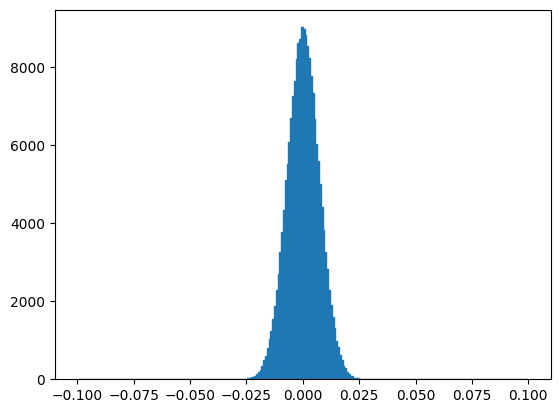

In [12]:
import numpy as np
import matplotlib.pyplot as plt


### choosing one of the attention weight matrices
state_dict = model.state_dict()
w = state_dict["blocks.0.attention.atten.weight"]

plt.hist(w.flatten().numpy(), bins = 250, range = (-0.1, 0.1), edgecolor = 'C0')
plt.show()


In [13]:
from torch import quantize_per_tensor
zero_point = 0
scale = (w.max() - w.min())/(127 -(-128))

q = (w/scale + zero_point).clamp(-128, 127).round().char()
q.size()

torch.Size([768, 256])

In [14]:
dtype = torch.qint8
qw = quantize_per_tensor(w, scale, zero_point, dtype)
qw.int_repr()
qw.size()

torch.Size([768, 256])

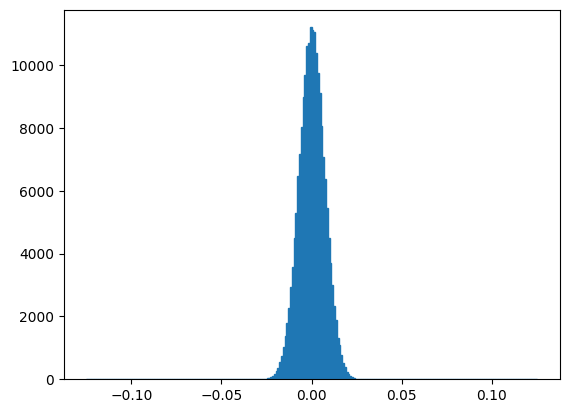

In [15]:
plt.hist(w.flatten(), bins = 250, range = (-0.125, 0.125), edgecolor = 'C0')
plt.show()

In [16]:
%%timeit

p = w * w

53.1 µs ± 1.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%%timeit
quantw = q * q

15.2 µs ± 966 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [18]:
import sys
sys.getsizeof(w.storage())/ sys.getsizeof(qw.storage())

<ipython-input-18-ba1baa55a96d>:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  sys.getsizeof(w.storage())/ sys.getsizeof(qw.storage())


3.9992677568952892

In [60]:
import torch
import time

# Define your models
model1 = BabyGPTmodel(config)
model2 = model_int8
# Define additional models as needed

# Set the models to evaluation mode
model1.eval()
model2.eval()
# Set additional models to evaluation mode



# Define the number of iterations for the benchmark
num_iterations = 10000

# Define dictionaries to store inference times
model_inference_times = {}

# Perform the benchmark for each model
for model_name, model in [("Model 1", model1), ("Model 2", model2)]:
    # Initialize a list to store inference times for the current model
    inference_times = []

    # Run the model for the specified number of iterations
    for _ in range(num_iterations):
        start_time = time.time()
        _ = model
        end_time = time.time()

        # Calculate the inference time
        inference_time = end_time - start_time

        # Append the inference time to the list
        inference_times.append(inference_time)

    # Store the inference times for the current model
    model_inference_times[model_name] = inference_times

# Print the benchmark results
for model_name, inference_times in model_inference_times.items():
    avg_inference_time = sum(inference_times) / len(inference_times)
    print(f"{model_name} average inference time: {avg_inference_time * 1000} ms")


number of parameters: 3222637
Model 1 average inference time: 0.00015320777893066404 ms
Model 2 average inference time: 0.0001468658447265625 ms


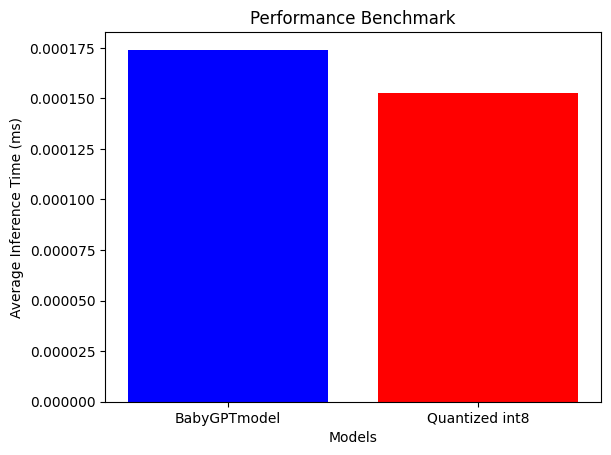

In [86]:
import matplotlib.pyplot as plt

# Define the models and their average inference times
models = [ 'BabyGPTmodel', 'Quantized int8']
inference_times = [0.00017404556274414062 , 0.000152587890625 ]  # Example average inference times in seconds

# Create a bar chart
plt.bar(models, inference_times, color=['blue', 'red'])

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Average Inference Time (ms)')
plt.title('Performance Benchmark')

# Show the plot
plt.show()

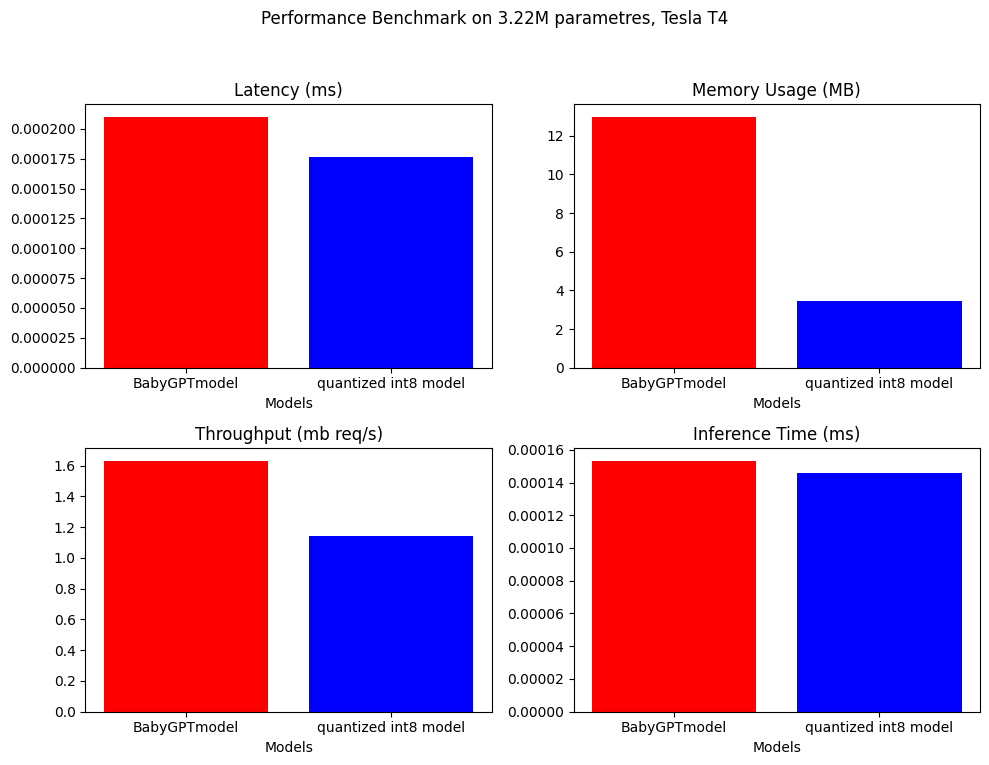

In [97]:
import matplotlib.pyplot as plt

# Define the models
models = ['BabyGPTmodel', 'quantized int8 model']

# Define the performance metrics
latency = [0.000210,  0.000176]  # Example latency values in milliseconds
memory = [12.98, 3.46]  # Example memory usage values in megabytes
throughput = [1.6311084996846195, 1.14]  # Example throughput values in requests per second
inference_time = [0.0001532077, 0.000146]  # Example inference time values in seconds


# Create a bar chart for each performance metric
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
colors = ['red', 'blue']
# Plot latency
axs[0, 0].bar(models, latency, color = colors)
axs[0, 0].set_title('Latency (ms)')
axs[0, 0].set_xlabel('Models')


# Plot memory
axs[0, 1].bar(models, memory, color = colors)
axs[0, 1].set_title('Memory Usage (MB)')
axs[0, 1].set_xlabel('Models')

# Plot throughput
axs[1, 0].bar(models, throughput, color = colors)
axs[1, 0].set_title('Throughput (mb req/s)')
axs[1, 0].set_xlabel('Models')

# Plot inference time
axs[1, 1].bar(models, inference_time, color = colors)
axs[1, 1].set_title('Inference Time (ms)')
axs[1, 1].set_xlabel('Models')

fig.suptitle('Performance Benchmark on 3.22M parametres, Tesla T4')


# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()
